# Proyek Klasifikasi Gambar: Lung Cancer Histopathological
- **Nama:** Anggi Maulana
- **Email:** anggimaulana23@student.polindra.ac.id
- **ID Dicoding:** anggi_maulana_07

## Import Semua Packages/Library yang Digunakan

In [2]:
# Import libraries
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Image processing
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize

# Model & Training
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.19.0


## Data Preparation

### Data Loading

In [4]:
os.environ["KAGGLE_USERNAME"] = "anggi13"
os.environ["KAGGLE_KEY"] = "KGAT_fa768addff22facc1ff882ff58824149"

In [5]:
# Download kaggle dataset and unzip the file
!kaggle datasets download -d rm1000/lung-cancer-histopathological-images

Dataset URL: https://www.kaggle.com/datasets/rm1000/lung-cancer-histopathological-images
License(s): CC-BY-SA-4.0
lung-cancer-histopathological-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip lung-cancer-histopathological-images.zip

Archive:  lung-cancer-histopathological-images.zip
replace adenocarcinoma/0000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace adenocarcinoma/0001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace adenocarcinoma/0002.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [7]:
# Definisi Path
base_dir = Path("lung-cancer-histopathological-images")
combined_dir = base_dir / "dataset"
source_dirs = ["adenocarcinoma", "benign", "squamous_cell_carcinoma"]

# Buat direktori tujuan
combined_dir.mkdir(parents=True, exist_ok=True)

# Proses Penggabungan Dataset
for folder in source_dirs:
    src_path = Path(folder)
    if src_path.exists():
        dest_path = combined_dir / folder
        # Menggunakan shutil.copytree untuk menyalin seluruh folder sebagai sub-folder di 'dataset'
        if not dest_path.exists():
            shutil.copytree(src_path, dest_path)
    else:
        print(f"Peringatan: Folder {folder} tidak ditemukan.")

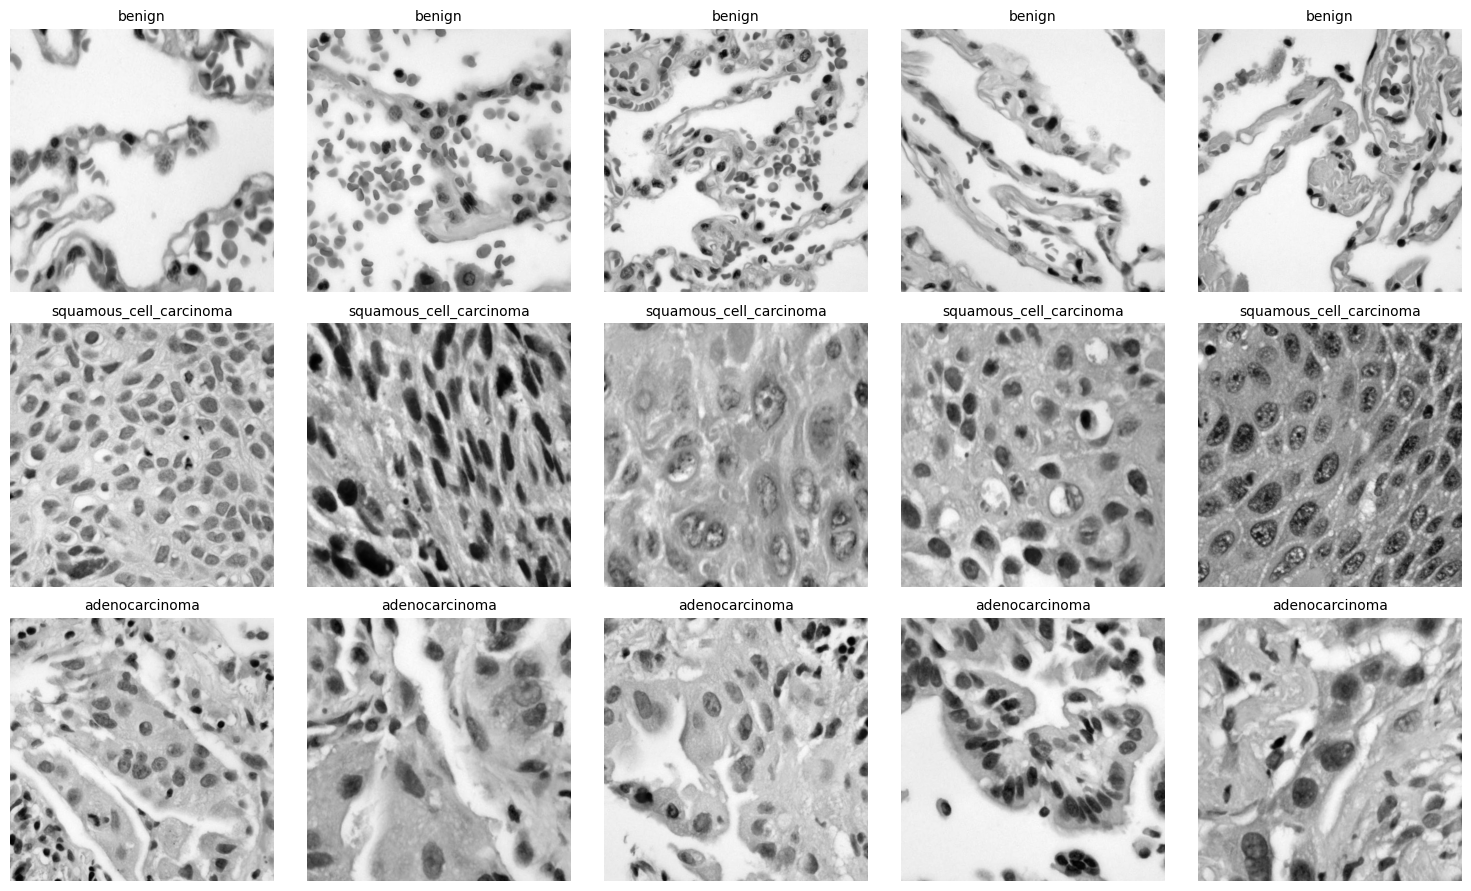

In [8]:
# Membangun Dictionary Gambar
lung_image = {}
if combined_dir.exists():
    for class_folder in combined_dir.iterdir():
        if class_folder.is_dir():
            # Simpan list file gambar (filter hanya file)
            images = [f.name for f in class_folder.glob('*') if f.is_file()]
            if images:
                lung_image[class_folder.name] = images

# Validasi Data sebelum Visualisasi
num_classes = len(lung_image)
fig, axs = plt.subplots(num_classes, 5, figsize=(15, 3 * num_classes))

# Jika hanya ada 1 kelas, axs akan berupa array 1D, kita ubah ke 2D untuk konsistensi index [i, j]
if num_classes == 1:
    axs = np.expand_dims(axs, axis=0)

for i, (class_name, image_list) in enumerate(lung_image.items()):
    # Ambil 5 sampel secara acak
    n_samples = min(len(image_list), 5)
    selected_images = np.random.choice(image_list, n_samples, replace=False)

    for j, image_name in enumerate(selected_images):
        img_path = combined_dir / class_name / image_name
        img = Image.open(img_path).convert("L")
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set_title(class_name, fontsize=10)
        axs[i, j].axis('off') # Menghilangkan axis untuk tampilan lebih bersih

plt.tight_layout()
plt.show()

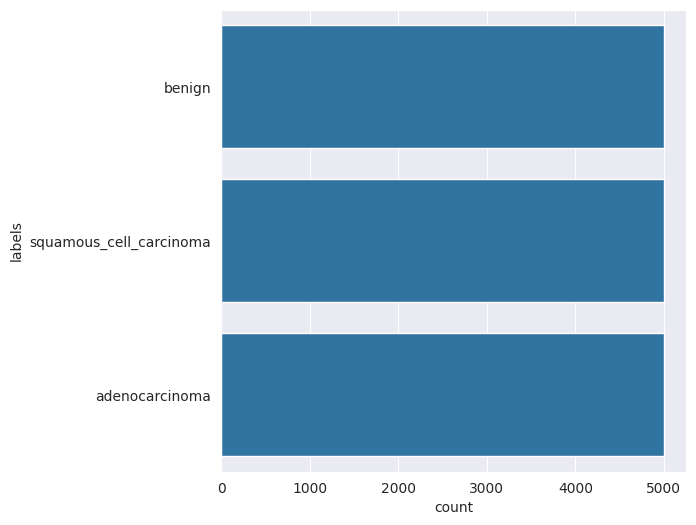

In [9]:
# Define source path
lung_path = "lung-cancer-histopathological-images/dataset/"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)
plt.show()

### Data Preprocessing

#### Split Dataset

In [10]:
SOURCE_PATH = 'lung-cancer-histopathological-images/dataset/'
FINAL_DATASET_DIR = "Dataset-Final/"
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

# Mengumpulkan path dan label secara rekursif
file_paths = []
labels = []

for root, dirs, files in os.walk(SOURCE_PATH):
    for name in files:
        if name.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_paths.append(os.path.join(root, name))
            labels.append(os.path.basename(root))

df = pd.DataFrame({"path": file_paths, "labels": labels})

In [11]:
# Pisahkan 20% untuk TEST
X_train_val, X_test, y_train_val, y_test = train_test_split(
    df['path'], df['labels'], test_size=0.2, random_state=300, stratify=df['labels']
)

# Pisahkan 20% dari Train_Val untuk VALIDATION
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=300, stratify=y_train_val
)

# Masukkan ke DataFrame dengan label set yang jelas
df_tr = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_va = pd.DataFrame({'path': X_val, 'labels': y_val, 'set': 'val'})
df_te = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})
df_all = pd.concat([df_tr, df_va, df_te], ignore_index=True)

In [12]:
# Copy file ke folder masing-masing
print("Memindahkan file ke folder Train, Val, dan Test...")
for _, row in tq(df_all.iterrows(), total=df_all.shape[0]):
    dest_dir = os.path.join(FINAL_DATASET_DIR, row['set'], row['labels'])
    os.makedirs(dest_dir, exist_ok=True)

    dest_file = os.path.join(dest_dir, os.path.basename(row['path']))
    if not os.path.exists(dest_file):
        shutil.copy2(row['path'], dest_file)

print(f"\nDistribusi Akhir:")
print(f"Train: {len(df_tr)}")
print(f"Val  : {len(df_va)}")
print(f"Test : {len(df_te)}")

Memindahkan file ke folder Train, Val, dan Test...


  0%|          | 0/15000 [00:00<?, ?it/s]


Distribusi Akhir:
Train: 9600
Val  : 2400
Test : 3000


In [13]:
# Define training and test directories
TRAIN_DIR = "Dataset-Final/train/"
VAL_DIR   = "Dataset-Final/val/"
TEST_DIR  = "Dataset-Final/test/"

# Augmentasi untuk training
train_datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.15,
    fill_mode='nearest'
)

# Val dan Test tanpa augmentasi
val_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=1,
    color_mode="grayscale",
    class_mode='categorical',
    shuffle=False
)

print("\nData generator siap!")

Found 9600 images belonging to 3 classes.
Found 2400 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.

Data generator siap!


## Modelling

In [14]:
model = Sequential([
    # Block 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Block 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Block 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Block 4
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Classifier
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile Model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,814,339 (25.99 MB)

 Trainable params: 6,813,379 (25.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [15]:
# Menghentikan training jika val_loss tidak turun selama 5 epoch
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Menyimpan model terbaik secara otomatis
checkpoint = ModelCheckpoint(
    'best_lung_cancer_model.keras',
    monitor='val_accuracy',
    save_best_only=True
)

# Mengurangi Learning Rate jika progress melambat agar konvergensi lebih halus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

callbacks_list = [early_stop, checkpoint, reduce_lr]

In [16]:
# Melatih model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=callbacks_list,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 87s 257ms/step - accuracy: 0.7037 - loss: 2.9924 - val_accuracy: 0.3333 - val_loss: 23.5492 - learning_rate: 0.0010
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 73s 244ms/step - accuracy: 0.8443 - loss: 0.4051 - val_accuracy: 0.5750 - val_loss: 10.1953 - learning_rate: 0.0010
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 74s 246ms/step - accuracy: 0.8698 - loss: 0.3494 - val_accuracy: 0.5667 - val_loss: 5.1963 - learning_rate: 0.0010
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 76s 255ms/step - accuracy: 0.8824 - loss: 0.2956 - val_accuracy: 0.4921 - val_loss: 5.6075 - learning_rate: 0.0010
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 71s 238ms/step - accuracy: 0.8946 - loss: 0.2693 - val_accuracy: 0.7946 - val_loss: 1.1541 - learning_rate: 0.0010
Epoch 6/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 73s 244ms/step - accuracy: 0.9082 - loss: 0.2456 - val_accuracy: 0.7842 - val_loss: 1.6646 - learning_rate: 0.0010
Epoch 7/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 73s 243ms/step - accuracy: 0

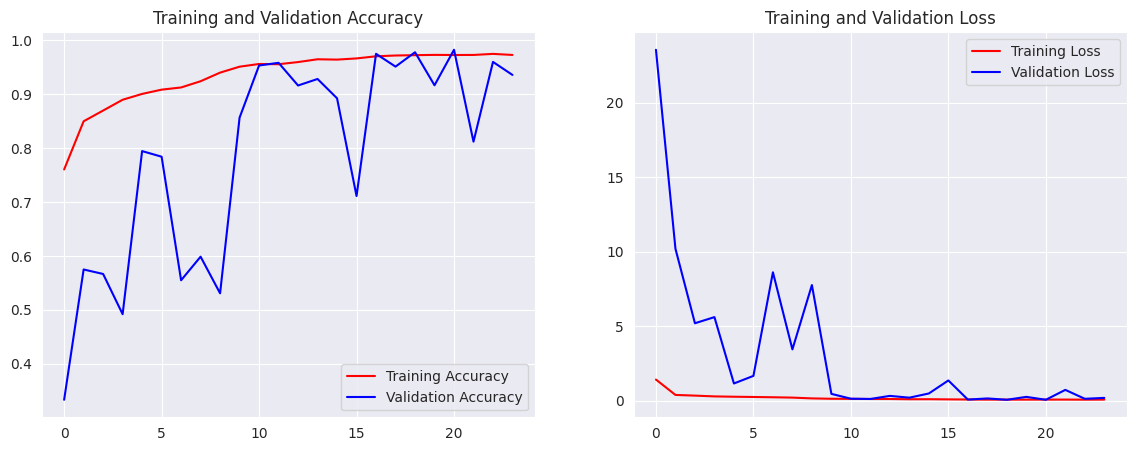

In [17]:
# Visualisasi Plot Akurasi dan Loss
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Plot Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_history(history)

## Evaluasi dan Visualisasi

3000/3000 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step


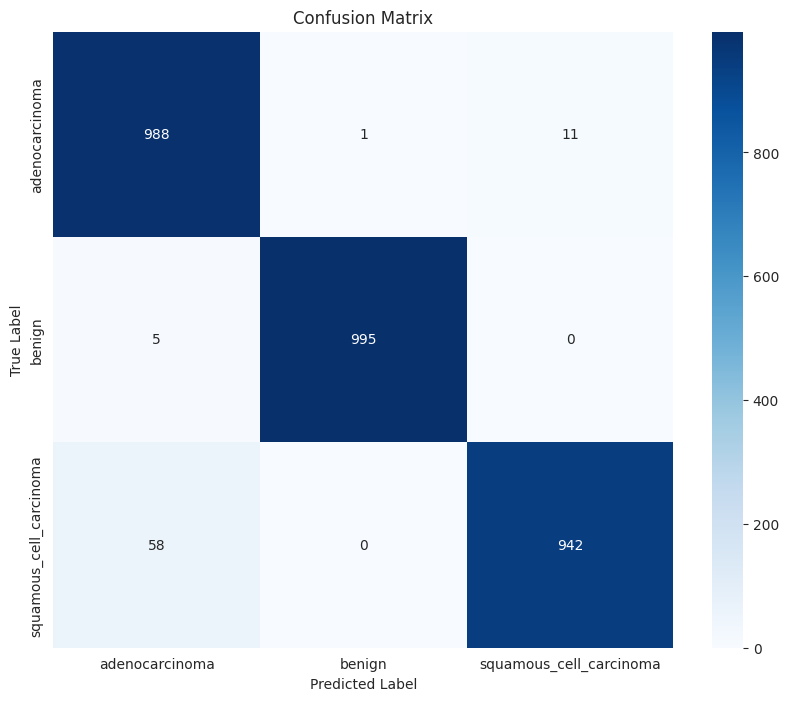


Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma     0.9401    0.9880    0.9634      1000
                 benign     0.9990    0.9950    0.9970      1000
squamous_cell_carcinoma     0.9885    0.9420    0.9647      1000

               accuracy                         0.9750      3000
              macro avg     0.9758    0.9750    0.9750      3000
           weighted avg     0.9758    0.9750    0.9750      3000



In [18]:
# Reset generator
test_generator.reset()

# Melakukan prediksi
preds = model.predict(test_generator, verbose=1)

# Mengambil index kelas dengan probabilitas tertinggi
y_pred = np.argmax(preds, axis=1)

# Mengambil label asli dari generator
y_true = test_generator.classes

# Mengambil nama kelas untuk label di plot
class_names = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

## Konversi Model

In [21]:
os.makedirs('models/saved_model', exist_ok=True)
os.makedirs('models/tflite', exist_ok=True)
os.makedirs('models/tfjs', exist_ok=True)

# SavedModel (gunakan export untuk TF 2.x)
model.export('models/saved_model')
print("✓ Model disimpan dalam format SavedModel")

# TF-Lite
converter = tf.lite.TFLiteConverter.from_saved_model('models/saved_model')
tflite_model = converter.convert()

with open('models/tflite/lung_cancer_model.tflite', 'wb') as f:
    f.write(tflite_model)
print("✓ Model dikonversi ke TF-Lite")

# TFJS
!pip install tensorflowjs
!tensorflowjs_converter --input_format=tf_saved_model models/saved_model models/tfjs
print("✓ Model dikonversi ke TensorFlow.js")

Saved artifact at 'models/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  132165258502096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132165258506512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132165258508432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132165258506128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132165258505936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132165258507472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132165258508048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132165258508240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132165258509968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132165258507664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132165258509

## Inference (Optional)

Model berhasil dimuat


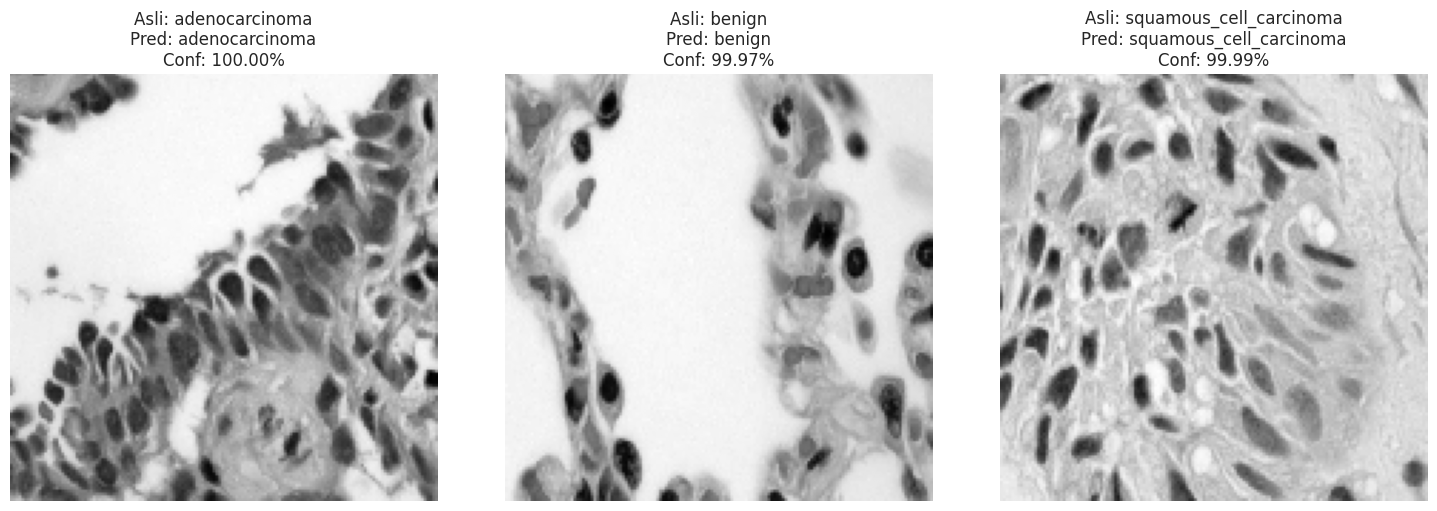


Selesai!


In [22]:
# Load model terbaik
loaded_model = tf.keras.models.load_model('best_lung_cancer_model.keras')
print("Model berhasil dimuat")

class_indices = test_generator.class_indices
labels_map = {v: k for k, v in class_indices.items()}

plt.figure(figsize=(15, 5))

for i, (cls_name, cls_idx) in enumerate(class_indices.items()):
    specific_class_path = os.path.join(TEST_DIR, cls_name)

    available_files = [f for f in os.listdir(specific_class_path)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    img_name = np.random.choice(available_files)
    full_img_path = os.path.join(specific_class_path, img_name)

    # Load dan preprocess
    img = image.load_img(full_img_path, target_size=(150, 150), color_mode="grayscale")
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Prediksi
    pred = loaded_model.predict(img_array, verbose=0)[0]
    pred_idx = np.argmax(pred)
    conf = pred[pred_idx] * 100

    # Visualisasi
    plt.subplot(1, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Asli: {cls_name}\nPred: {labels_map[pred_idx]}\nConf: {conf:.2f}%")
    plt.axis('off')

plt.tight_layout()
plt.show()

print("\nSelesai!")